In [1]:
targetFolderHBK = r"H:\Extracted_Features\HBK\HBK_14285Hz_bandpass_all_features\features"
targetFolderMCC5 = r"H:\Extracted_Features\MCC5\MCC5_12800Hz_bandpass_all_features_motor_vibration_x\features"
normalization_method = "z_score"

In [2]:
experiment_name = "bandpass_data_analysis_binary"
project_name="bandpass_data_analysis_binary",
run_name="bandpass_data_analysis_binary"
domain="all"

domains_to_use = ['time', 'frequency', 'time-frequency']

In [3]:
binary_classification=True
plot_histograms_choice=False
include_augmentations=False

# Environment Setup & Imports

In [4]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import numpy as np
import mlflow
from pytorch_lightning.loggers import MLFlowLogger
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, hamming_loss, hinge_loss, jaccard_score, log_loss, precision_score, recall_score, f1_score, make_scorer
from pathlib import Path
from pycaret.classification import * 
from torch import tensor
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy
import optuna
import torch
from sklearn.model_selection import train_test_split
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig, CategoryEmbeddingModel,GatedAdditiveTreeEnsembleConfig, NodeConfig, FTTransformerConfig, TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    ModelConfig,
    TrainerConfig,
    ExperimentConfig,
)
from collections import Counter
from data_loader import load_feature_data

## Helper Functions

In [5]:
def select_features_by_domain(domains: list, available_features: dict = None) -> list:
    """
    Selects a list of features based on the specified domains.

    Args:
        domains: A list of domain names (e.g., ['time', 'frequency']).
        available_features: A dictionary mapping domain names (keys) to 
                            lists of features (values). If None, uses a 
                            default dictionary.

    Returns:
        A flat list of all selected features.
    """
    # Define the complete feature set structure
    if available_features is None:
        available_features = {
            'time': ['rms', 'std', 'crest', 'energy', 'entropy'],
            'frequency': ['meanFreq', 'medianFreq', 'spectral_entropy', 'spectral_skewness'],
            # Assuming 'Time-Frequency' is referred to by a simpler domain name, 
            # or you can keep the full name
            'time-frequency': ['meanWavelet', 'varWavelet', 'entropyWavelet', 'entropySpectrogram']
        }

    selected_features = []
    
    # Iterate over the requested domains and extend the list
    for domain in domains:
        # Convert domain to lowercase for case-insensitive matching
        domain_key = domain.lower().replace('_', '-').strip()
        
        if domain_key in available_features:
            selected_features.extend(available_features[domain_key])
        else:
            print(f"Warning: Domain '{domain}' not recognized in available features.") # Optional warning

    # Return only unique features in case of overlap (though unlikely here)
    return list(set(selected_features))

In [6]:
features_to_include = select_features_by_domain(domains=domains_to_use)

In [7]:
def plotHistograms(dataframe, normalization):
    for col in dataframe.columns:
        if col == "Label":
            continue
        plt.figure(figsize=(8, 4))
        sns.histplot(data = dataframe, x=col, hue='Label', kde=True, multiple='layer', element='step', alpha=0.5)
        plt.title(f"Distribution of {col} with {normalization}")
        plt.show()

In [8]:
def normalizeDataframe(dataframe, normalization_method):
    """
    Normalizes the features of a dataframe using a specified method.

    Args:
        dataframe (pd.DataFrame): The input dataframe with a 'Label' column.
        normalization_method (str): The method to use ("min_max", "z_score", "robust_scaling").

    Returns:
        pd.DataFrame: The dataframe with scaled features.
    """
    # Separate features (X) and the target variable (y)
    y = dataframe['Label']
    X = dataframe.drop(columns=['Label'])

    # Select the scaler based on the chosen method
    if normalization_method == "min_max":
        scaler = MinMaxScaler()
    elif normalization_method == "z_score":
        scaler = StandardScaler()
    elif normalization_method == "robust_scaling":
        scaler = RobustScaler()
    else:
        # Raise an error for an invalid method name
        raise ValueError(f"Unknown normalization_method: '{normalization_method}'")

    # Fit the scaler to the data and transform it
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Rejoin the scaled features with the label column
    df_scaled = X_scaled.join(y)
    
    return df_scaled

In [9]:
def plotPredictionHistograms(df, normalization):
    # 1) mark correct vs incorrect
    df = df.copy()
    df['prediction_quality'] = np.where(
        df['Label'] == df['prediction_label'],
        'correct',
        'incorrect'
    )
    
    # 2) choose a palette (you can override these colors if you like)
    pal = dict(zip(
        ['correct','incorrect'],
        sns.color_palette(n_colors=2)
    ))
    
    skip = {'Label','prediction_label','prediction_score','prediction_quality'}
    for col in df.columns:
        if col in skip:
            continue
        
        fig, ax = plt.subplots(figsize=(8,4))
        sns.histplot(
            data=df, x=col, hue='prediction_quality',
            palette=pal,
            kde=True, multiple='layer', element='step',
            alpha=0.5,
            ax=ax
        )
        
        # 3) build a manual legend using the same palette
        handles = [
            mpatches.Patch(color=pal[k], label=k)
            for k in ['correct','incorrect']
        ]
        ax.legend(
            handles=handles,
            title='Prediction Quality'
        )
        
        ax.set_title(
            f"Distribution of {col}\n"
            f"(normalization = '{normalization}')"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        plt.show()

In [10]:
def get_incorrect_predictions(df):
    return df[
        ((df['Label'] == 'damaged')   & (df['prediction_label'] == 'healthy'))
      | ((df['Label'] == 'healthy')  & (df['prediction_label'] == 'damaged'))
    ].copy()

In [11]:
def get_feature_importance_df(model, df):
    importance = model.feature_importances_
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': importance
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [12]:
def get_svm_feature_importance_df(model, df):
    if not hasattr(model, 'coef_'):
        raise ValueError("This SVM model has no coefficients. Use a linear kernel.")
    
    importance = model.coef_.ravel()  # Flatten in case of binary classification
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': abs(importance)
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)


In [13]:
feature_counter = Counter()
def add_top_features(feature_df: pd.DataFrame, top_n: int):
    top_features = feature_df.nlargest(top_n, 'importance')['Features']
    feature_counter.update(top_features)
    
def plot_feature_importance():
    feature_freq = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_freq.sort_values(by='Count', ascending=False),
                x='Feature', y='Count')
    plt.xticks(rotation=45)
    plt.title('Feature Frequency Across Experiments')
    plt.tight_layout()
    plt.show()

In [14]:
def save_feature_counter(exp_name: str, folder: str = f"top_features_{experiment_name}"):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, f"{exp_name}_features.csv")
    df = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    df.to_csv(filepath, index=False)

## Import Dataset

In [15]:
df_HBK = load_feature_data(
    features_path=targetFolderHBK,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 156 files into a DataFrame with shape (193823, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['varWavelet', 'entropyWavelet', 'meanFreq', 'crest', 'energy', 'entropySpectrogram', 'rms', 'meanWavelet', 'spectral_skewness', 'entropy', 'std', 'spectral_entropy', 'medianFreq']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (193823, 14)


In [16]:
df_MCC5 = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 36 files into a DataFrame with shape (53928, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['varWavelet', 'entropyWavelet', 'meanFreq', 'crest', 'energy', 'entropySpectrogram', 'rms', 'meanWavelet', 'spectral_skewness', 'entropy', 'std', 'spectral_entropy', 'medianFreq']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (53928, 14)


In [17]:
combined_df = pd.concat([df_HBK, df_MCC5], ignore_index=True)

In [18]:
normalized_df = normalizeDataframe(combined_df, normalization_method)

In [19]:
features_df_training_normalized, features_df_testing_normalized = train_test_split(
    normalized_df, 
    test_size=0.2,    # e.g., 20% for testing
    random_state=42   # for reproducibility
)

# Histograms

## Histograms Training and Testing [NO-Normalization]

In [20]:
if (plot_histograms_choice):
    plotHistograms(combined_df, normalization_method)

## Histograms Training and Testing [Z-Score Normalization]

In [21]:
if (plot_histograms_choice):
    plotHistograms(normalized_df, normalization_method)

# Experiment Setup (ML)

## Setup Hyperparameters

In [22]:
experiment = setup(features_df_training_normalized, target='Label', log_experiment = True, experiment_name = experiment_name, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

,Description,Value
0,Session id,3647
1,Target,Label
2,Target type,Binary
3,Target mapping,"damaged: 0, healthy: 1"
4,Original data shape,"(198200, 14)"
5,Transformed data shape,"(198200, 14)"
6,Transformed train set shape,"(138740, 14)"
7,Transformed test set shape,"(59460, 14)"
8,Numeric features,13
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [23]:
experiment.y_test

22921     damaged
145387    damaged
163659    damaged
82898     healthy
165349    damaged
           ...   
244320    damaged
11224     healthy
174870    damaged
112477    damaged
163629    damaged
Name: Label, Length: 59460, dtype: category
Categories (2, object): ['damaged', 'healthy']

## Add aditional metrics

In [24]:
# Binary classification metrics
add_metric('balanced_acc', 'Balance Acc', balanced_accuracy_score, target='pred', greater_is_better=True)
add_metric('hamming_loss', 'Hamming Loss', hamming_loss, target='pred', greater_is_better=False)
add_metric('jaccard_score', 'Jaccard Score', jaccard_score, target='pred', greater_is_better=True)
add_metric('log_loss', 'Log Loss', log_loss, target='pred_proba', greater_is_better=False)

Name                                                          Log Loss
Display Name                                                  Log Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: log_loss, dtype: object

In [25]:
all_metrics = get_metrics()
all_metrics

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000001C34E7CF2E0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000001C34E7CF...,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000001C34E7CF...,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False
balanced_acc,Balance Acc,Balance Acc,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(balanced_accuracy_score, response_...",pred,{},True,True,True
hamming_loss,Hamming Loss,Hamming Loss,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(hamming_loss, greater_is_better=Fa...",pred,{},False,True,True


## Light Gradient Boosting Machine

In [26]:
bestParamsLIGHTGBM = {
    'bagging_fraction': 0.8455104741417432,
    'bagging_freq': 0,
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'device': 'gpu',
    'feature_fraction': 0.42947671039481,
    'importance_type': 'split',
    'learning_rate': 0.47910287588557177,
    'max_depth': -1,
    'min_child_samples': 41,
    'min_child_weight': 0.001,
    'min_split_gain': 0.23016472358397666,
    'n_estimators': 245,
    'n_jobs': -1,
    'num_leaves': 250,
    'objective': None,
    'random_state': 1768,
    'reg_alpha': 0.00039695268896179983,
    'reg_lambda': 3.6071600095045767e-06,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}


In [27]:
lightgbm = create_model('lightgbm', **bestParamsLIGHTGBM)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
Fold,,,,,,,,,,,
0,0.9525,0.9843,0.9525,0.9520,0.9516,0.8562,0.8580,0.9131,0.0475,0.7955,0.1221
1,0.9507,0.9827,0.9507,0.9502,0.9497,0.8504,0.8524,0.9094,0.0493,0.7880,0.1261
2,0.9496,0.9830,0.9496,0.9490,0.9487,0.8474,0.8492,0.9086,0.0504,0.7843,0.1264
3,0.9482,0.9817,0.9482,0.9475,0.9473,0.8434,0.8450,0.9077,0.0518,0.7795,0.1319
4,0.9439,0.9792,0.9439,0.9430,0.9427,0.8295,0.8316,0.8989,0.0561,0.7618,0.1404
5,0.9482,0.9830,0.9482,0.9476,0.9473,0.8433,0.8451,0.9067,0.0518,0.7791,0.1279
6,0.9476,0.9815,0.9476,0.9469,0.9466,0.8415,0.8432,0.9063,0.0524,0.7770,0.1332
7,0.9463,0.9812,0.9463,0.9456,0.9452,0.8371,0.8391,0.9028,0.0537,0.7712,0.1327
8,0.9448,0.9799,0.9448,0.9441,0.9435,0.8317,0.8342,0.8986,0.0552,0.7642,0.1371


Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


2025/10/08 10:16:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [28]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [29]:
lightgbm_top_features = get_feature_importance_df(lightgbm, features_df_training_normalized)
lightgbm_top_features

,Features,importance
0,spectral_skewness,1323
1,crest,994
2,meanWavelet,771
3,meanFreq,608
4,medianFreq,569
5,spectral_entropy,516
6,entropySpectrogram,398
7,entropyWavelet,356
8,entropy,339
9,varWavelet,319


In [30]:
add_top_features(lightgbm_top_features, top_n=3)

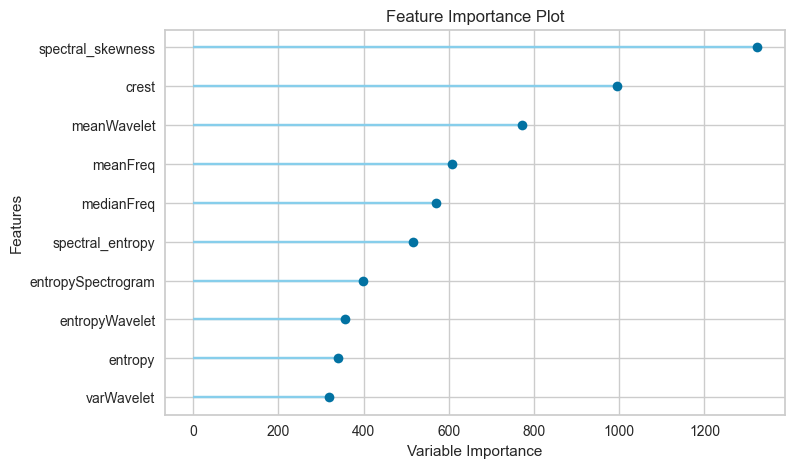

In [31]:
plot_model(lightgbm, plot='feature')

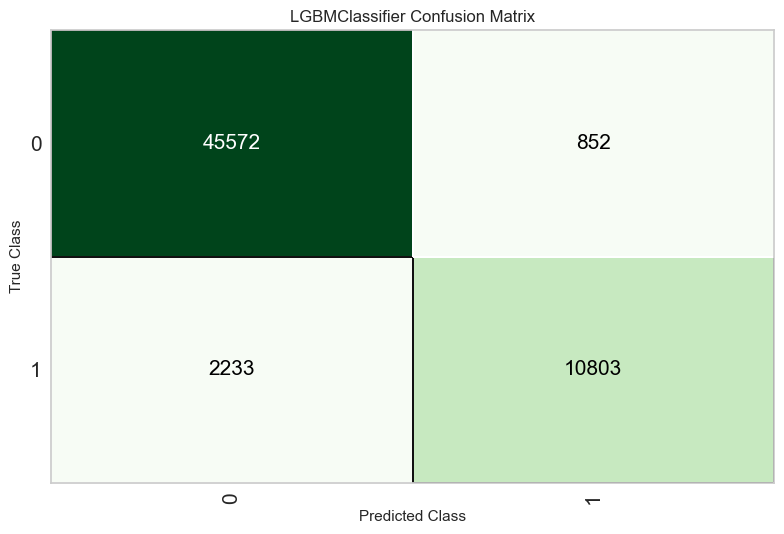

In [32]:
plot_model(lightgbm, plot='confusion_matrix')

In [33]:
predictions_lightgbm = predict_model(lightgbm, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Light Gradient Boosting Machine,0.9481,0.9813,0.9481,0.9474,0.9470,0.8405,0.8424,0.9047,0.0519,0.7746,0.1305


[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [34]:
predictions_lightgbm

,varWavelet,entropyWavelet,meanFreq,crest,energy,entropySpectrogram,rms,meanWavelet,spectral_skewness,entropy,std,spectral_entropy,medianFreq,Label,prediction_label,prediction_score
122281,-0.112212,0.020339,-0.915750,-0.575082,-0.111857,-0.110021,0.203390,0.218045,-1.471315,0.043586,0.203371,-0.094193,-0.919695,damaged,damaged,1.0000
239138,-0.197515,-0.427248,-0.373380,0.562391,-0.197790,-0.111429,-0.493504,-0.490533,1.171264,-0.454461,-0.493502,-0.243274,-0.364857,damaged,damaged,0.7400
39200,-0.197999,-0.432176,-1.339556,0.337677,-0.198277,-0.111429,-0.548404,-0.545931,-0.533786,-0.460030,-0.548405,-0.244594,-1.344168,healthy,healthy,0.9985
90804,-0.197698,-0.428946,-0.483944,-0.668357,-0.197972,-0.111429,-0.505306,-0.501749,0.738338,-0.456380,-0.505307,-0.243772,-0.489195,damaged,damaged,0.9239
102120,-0.133636,-0.089089,0.372752,0.261288,-0.134939,-0.110497,0.094966,0.061754,-1.270834,-0.075154,0.094980,-0.133465,0.377539,damaged,damaged,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36543,-0.181299,-0.317511,-0.055742,-0.710791,-0.181407,-0.111370,-0.217189,-0.206434,0.870245,-0.331742,-0.217193,-0.210105,-0.055977,damaged,damaged,0.9996
168305,0.342832,1.480334,-0.913569,-0.683566,0.348437,-0.063438,1.345079,1.397340,-1.413586,1.624993,1.345120,0.554588,-0.917967,damaged,damaged,1.0000
211082,-0.195991,-0.414835,2.455221,0.667958,-0.196293,-0.111428,-0.435908,-0.438358,1.106077,-0.440407,-0.435905,-0.239551,2.441782,damaged,damaged,0.9339
91824,-0.191212,-0.379109,-1.341601,-0.419809,-0.191339,-0.111418,-0.336592,-0.322879,-0.398170,-0.400540,-0.336633,-0.229596,-1.343992,damaged,damaged,0.9999


In [35]:
get_incorrect_predictions(predictions_lightgbm)

,varWavelet,entropyWavelet,meanFreq,crest,energy,entropySpectrogram,rms,meanWavelet,spectral_skewness,entropy,std,spectral_entropy,medianFreq,Label,prediction_label,prediction_score
26179,-0.197283,-0.425219,0.804163,-0.486499,-0.197563,-0.111429,-0.481605,-0.480299,-0.510230,-0.452153,-0.481604,-0.242683,0.807772,damaged,healthy,0.7788
84362,-0.194046,-0.400525,0.803713,1.696636,-0.194353,-0.111425,-0.389526,-0.391532,-0.533195,-0.424399,-0.389523,-0.236963,0.808386,healthy,damaged,0.8883
197882,-0.180709,-0.317707,2.439638,-0.225674,-0.181217,-0.111335,-0.215312,-0.228436,1.133629,-0.331005,-0.215304,-0.204985,2.438644,healthy,damaged,0.9522
218377,-0.192857,-0.392234,1.039835,-0.572560,-0.193208,-0.111421,-0.367605,-0.374280,1.245569,-0.414846,-0.367600,-0.232021,1.037531,damaged,healthy,0.5312
202058,-0.188197,-0.364394,2.448043,1.730617,-0.188739,-0.111395,-0.299776,-0.320751,1.221221,-0.383507,-0.299770,-0.225172,2.439893,healthy,damaged,0.7801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45163,-0.197349,-0.425687,-0.916449,-0.460413,-0.197619,-0.111429,-0.484337,-0.480036,-1.486776,-0.452708,-0.484336,-0.242916,-0.919442,damaged,healthy,0.9320
30124,-0.197921,-0.431262,0.378745,0.328544,-0.198199,-0.111429,-0.527433,-0.525736,-1.470977,-0.458993,-0.527433,-0.244373,0.382019,damaged,healthy,0.5897
1047,-0.197594,-0.428018,0.377562,-0.185524,-0.197873,-0.111429,-0.498548,-0.497001,-1.436003,-0.455321,-0.498547,-0.243498,0.383432,healthy,damaged,0.8275
222712,-0.197962,-0.431716,1.040406,2.603172,-0.198240,-0.111429,-0.534385,-0.532510,1.252732,-0.459508,-0.534384,-0.244494,1.036682,damaged,healthy,0.5792


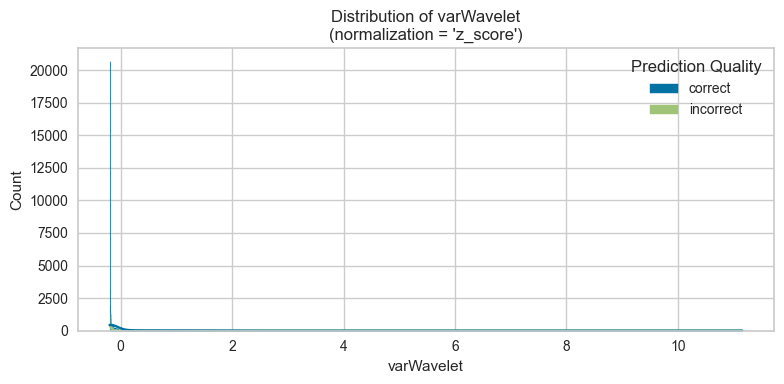

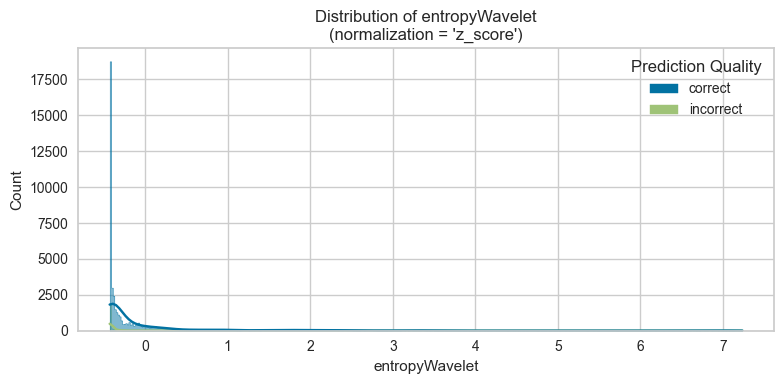

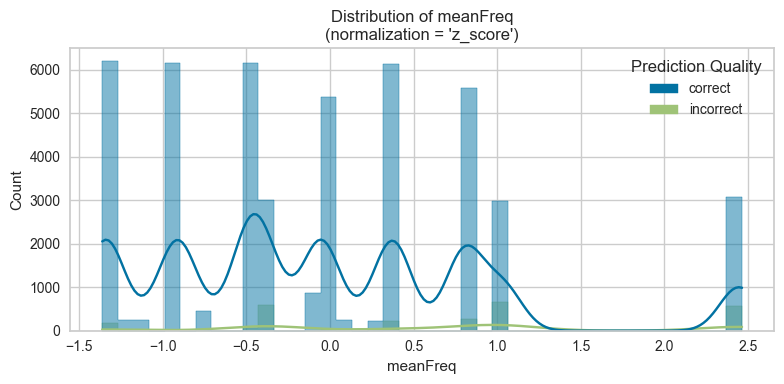

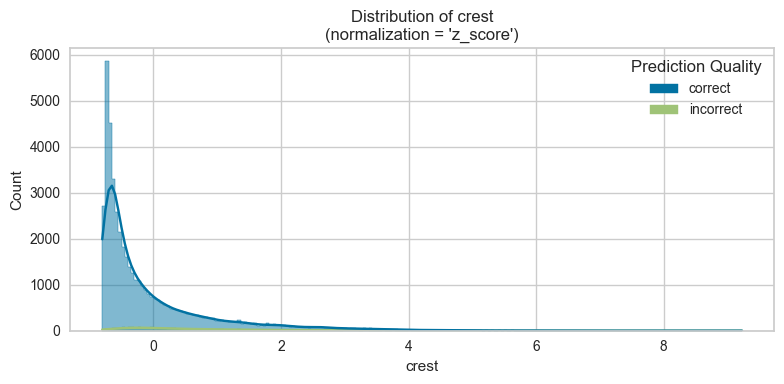

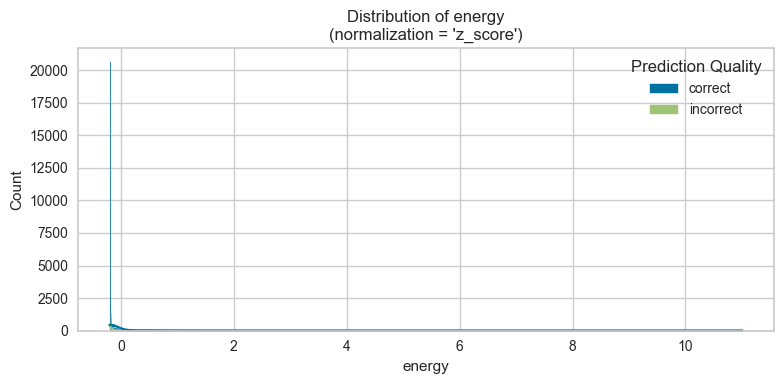

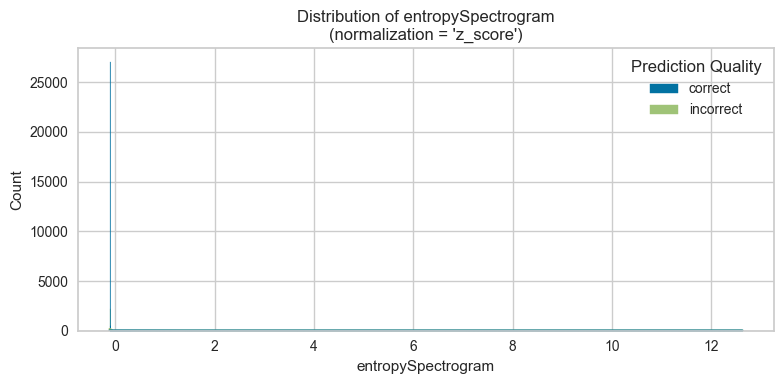

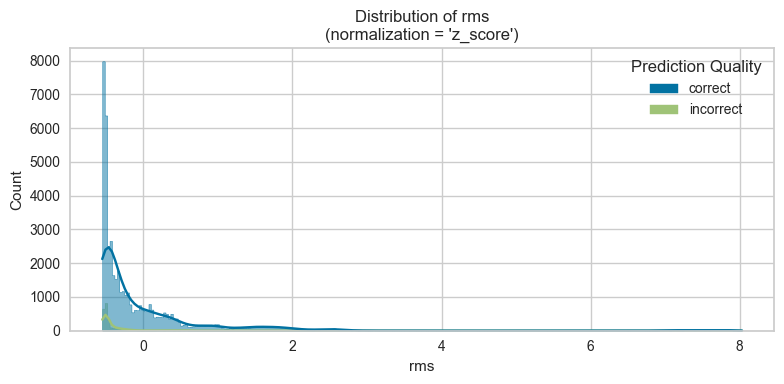

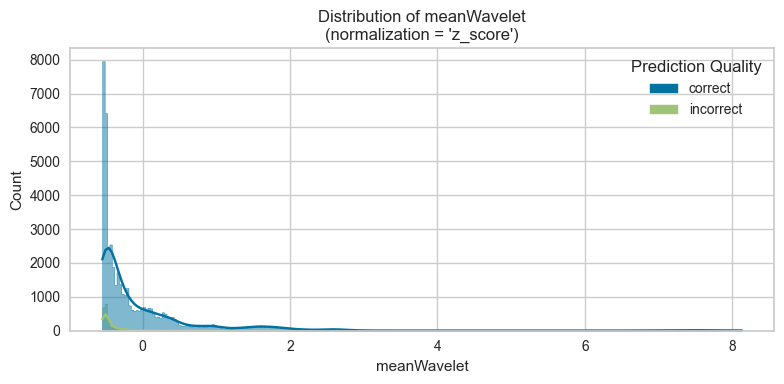

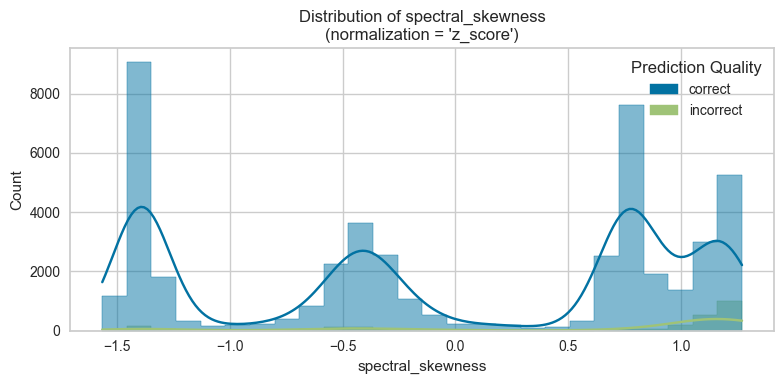

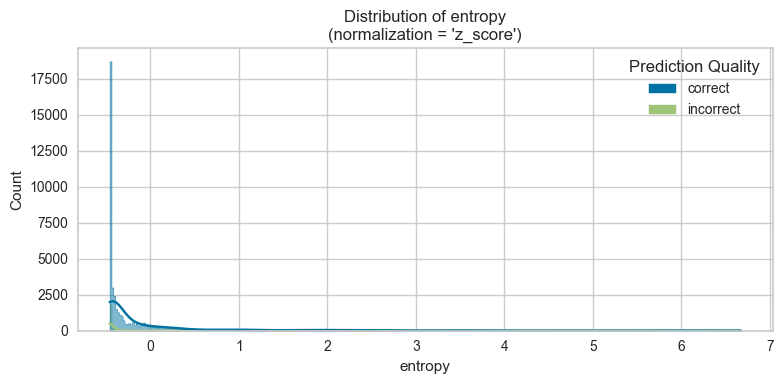

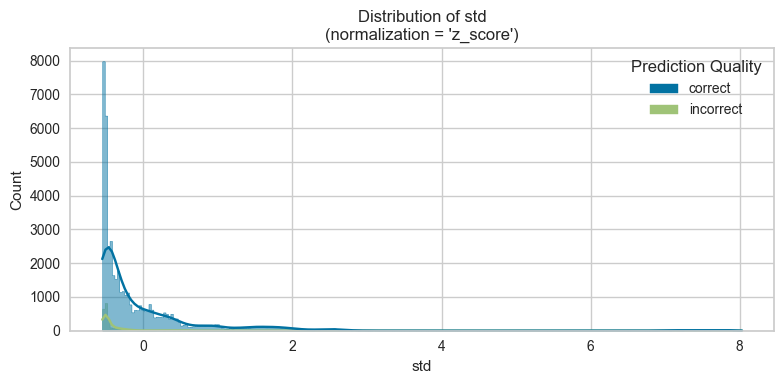

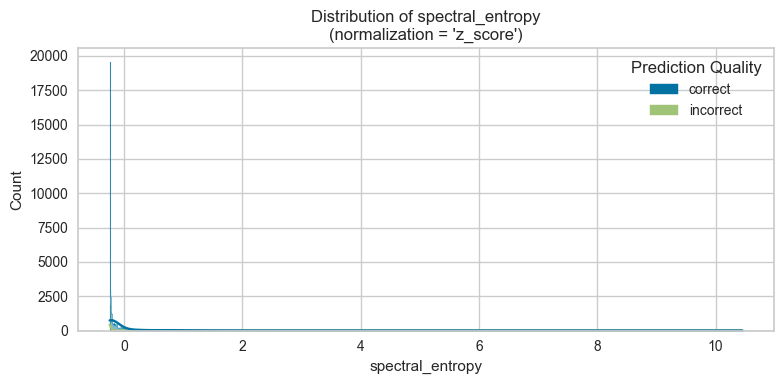

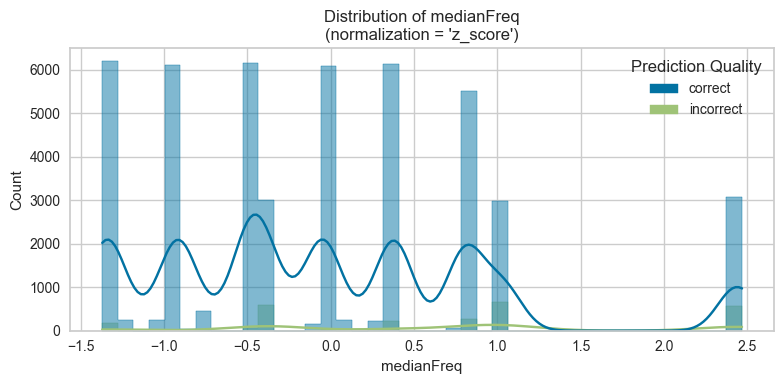

In [36]:
plotPredictionHistograms(predictions_lightgbm, normalization_method)

## Random Forest Classifier

In [37]:
bestParamsRF = {
    'bootstrap':True, 
    'ccp_alpha':0.0, 
    'class_weight':None,
    'criterion':'gini', 
    'max_depth':None, 
    'max_features':'sqrt',
    'max_leaf_nodes':None, 
    'max_samples':None,
    'min_impurity_decrease':0.0, 
    'min_samples_leaf':1,
    'min_samples_split':2, 
    'min_weight_fraction_leaf':0.0,
    'monotonic_cst':None, 
    'n_estimators':100, 
    'n_jobs':-1,
    'oob_score':False, 
    'random_state':1768, 
    'verbose':False,
    'warm_start':False
}

In [38]:
rf = create_model('rf', **bestParamsRF)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [39]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [40]:
rf_top_features = get_feature_importance_df(rf, features_df_training_normalized)
rf_top_features

,Features,importance
0,medianFreq,0.150058
1,meanFreq,0.140340
2,spectral_skewness,0.128749
3,std,0.085871
4,spectral_entropy,0.079385
5,rms,0.075999
6,varWavelet,0.066062
7,energy,0.059786
8,meanWavelet,0.055159
9,crest,0.052196


In [41]:
add_top_features(rf_top_features, top_n=3)

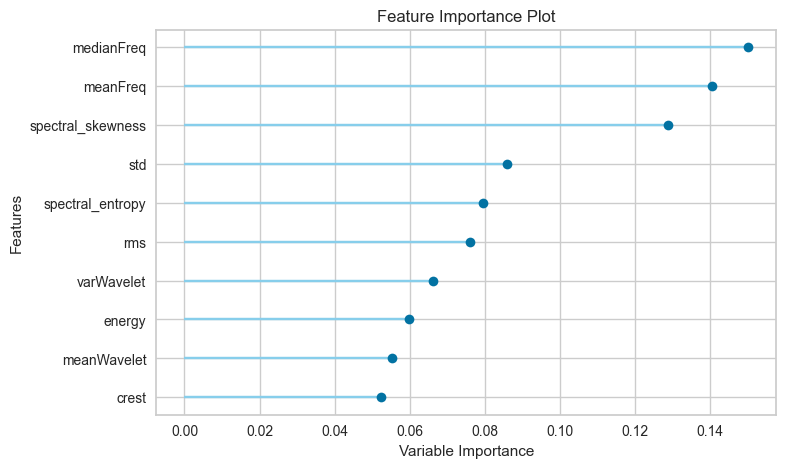

In [42]:
plot_model(rf, plot='feature')

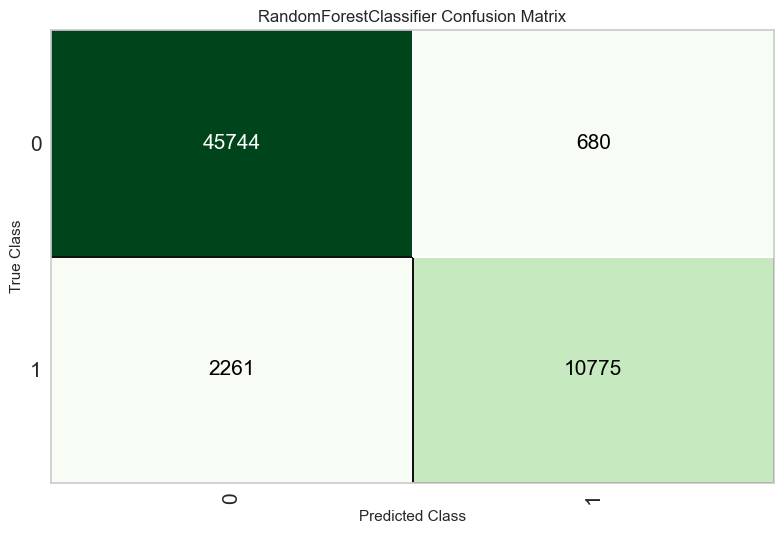

In [43]:
plot_model(rf, plot='confusion_matrix')

In [44]:
predictions_rf = predict_model(rf, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Random Forest Classifier,0.9512,0.9817,0.9512,0.9509,0.9501,0.8492,0.8520,0.9059,0.0488,0.7851,0.1403


In [45]:
get_incorrect_predictions(predictions_rf)

,varWavelet,entropyWavelet,meanFreq,crest,energy,entropySpectrogram,rms,meanWavelet,spectral_skewness,entropy,std,spectral_entropy,medianFreq,Label,prediction_label,prediction_score
90804,-0.197698,-0.428946,-0.483944,-0.668357,-0.197972,-0.111429,-0.505306,-0.501749,0.738338,-0.456380,-0.505307,-0.243772,-0.489195,damaged,healthy,0.59
26179,-0.197283,-0.425219,0.804163,-0.486499,-0.197563,-0.111429,-0.481605,-0.480299,-0.510230,-0.452153,-0.481604,-0.242683,0.807772,damaged,healthy,0.71
84362,-0.194046,-0.400525,0.803713,1.696636,-0.194353,-0.111425,-0.389526,-0.391532,-0.533195,-0.424399,-0.389523,-0.236963,0.808386,healthy,damaged,0.77
197882,-0.180709,-0.317707,2.439638,-0.225674,-0.181217,-0.111335,-0.215312,-0.228436,1.133629,-0.331005,-0.215304,-0.204985,2.438644,healthy,damaged,0.93
202058,-0.188197,-0.364394,2.448043,1.730617,-0.188739,-0.111395,-0.299776,-0.320751,1.221221,-0.383507,-0.299770,-0.225172,2.439893,healthy,damaged,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197707,-0.054448,0.238884,2.439948,-0.071006,-0.056218,-0.106562,0.415962,0.382701,1.177218,0.289527,0.415984,0.009995,2.439791,healthy,damaged,0.55
199165,-0.197770,-0.429717,-0.355989,1.980913,-0.198048,-0.111429,-0.511258,-0.509103,0.977268,-0.457257,-0.511259,-0.243997,-0.359772,healthy,damaged,0.75
45163,-0.197349,-0.425687,-0.916449,-0.460413,-0.197619,-0.111429,-0.484337,-0.480036,-1.486776,-0.452708,-0.484336,-0.242916,-0.919442,damaged,healthy,0.55
30124,-0.197921,-0.431262,0.378745,0.328544,-0.198199,-0.111429,-0.527433,-0.525736,-1.470977,-0.458993,-0.527433,-0.244373,0.382019,damaged,healthy,0.60


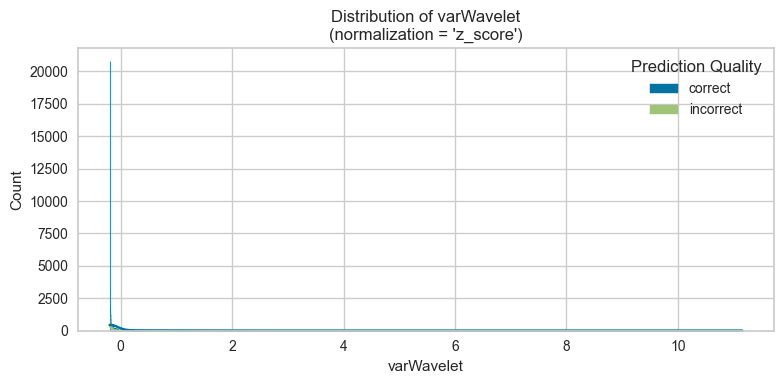

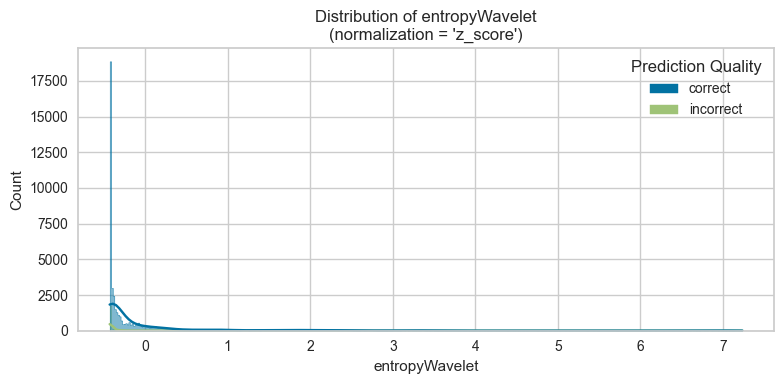

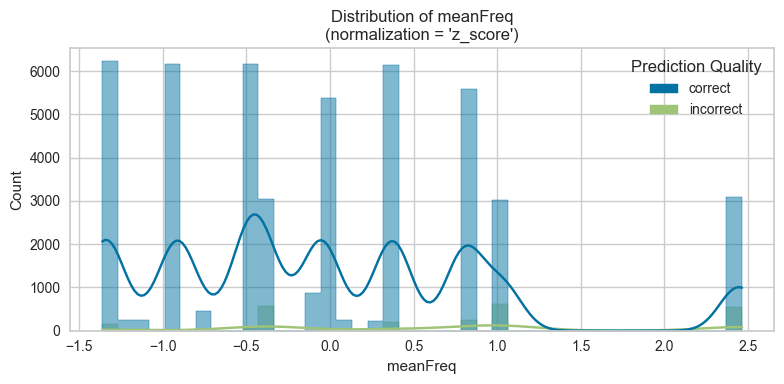

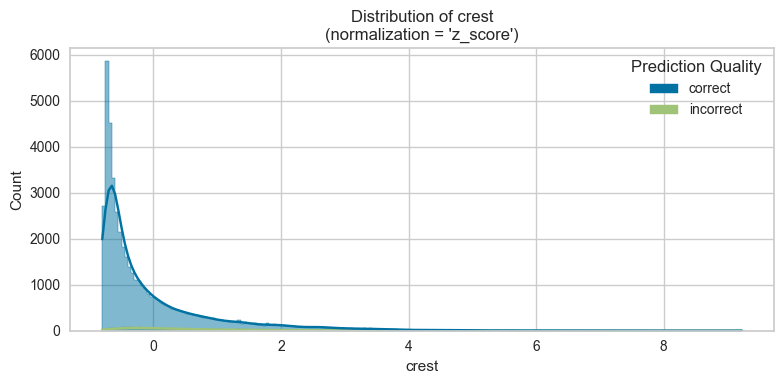

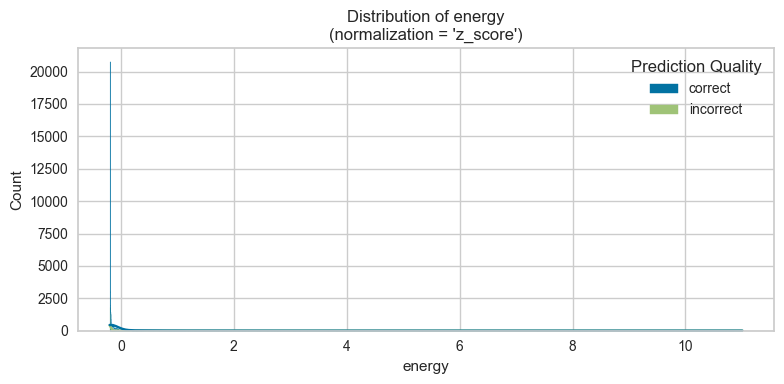

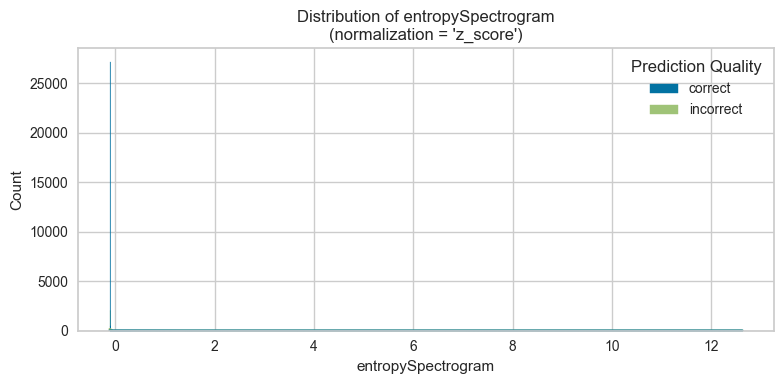

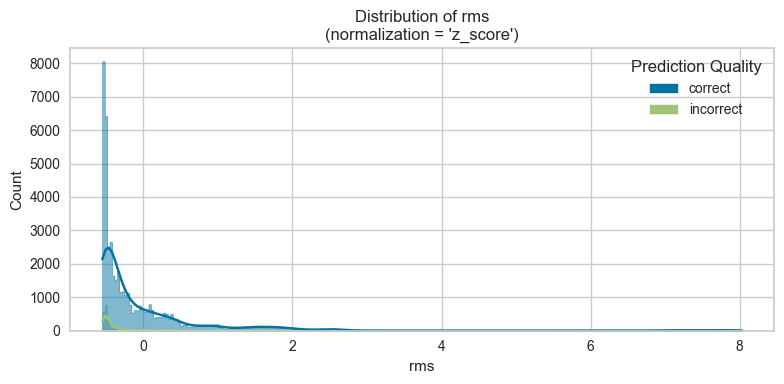

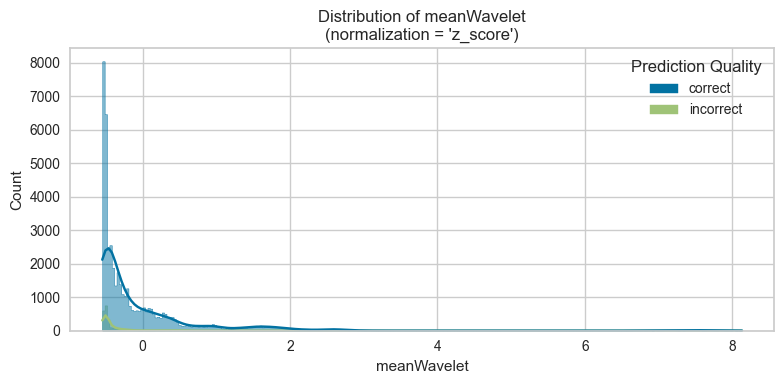

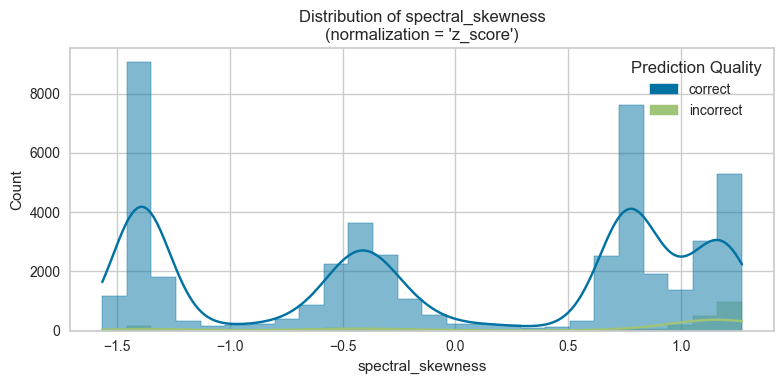

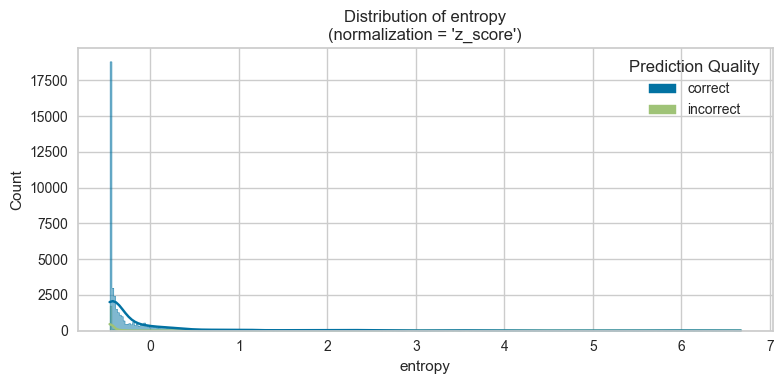

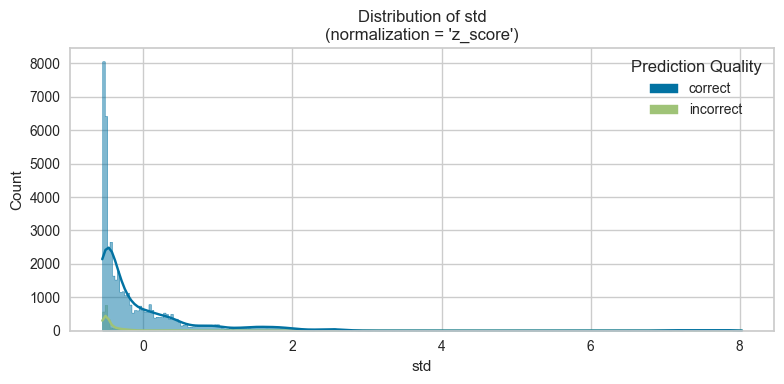

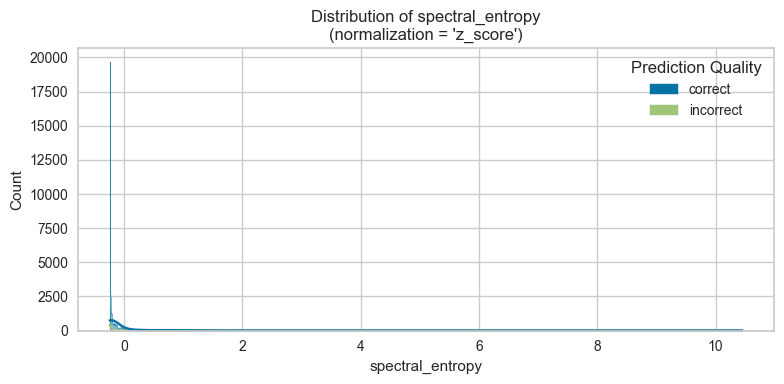

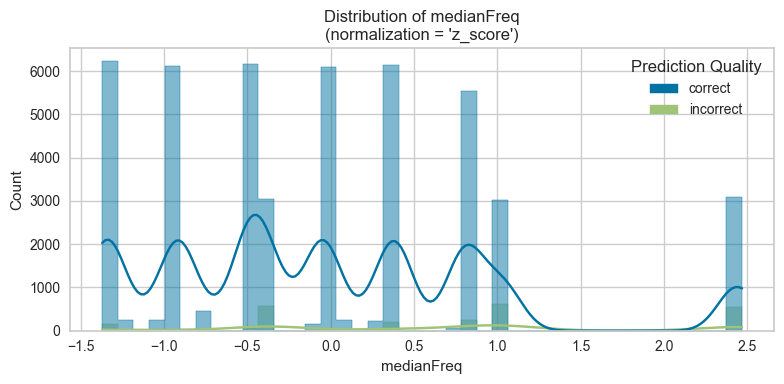

In [46]:
plotPredictionHistograms(predictions_rf, normalization_method)

## SVM

In [47]:
bestParamsSVM = {
    'alpha':1.983570694577895e-06, 
    'average':False, 
    'class_weight':None,
    'early_stopping':False, 
    'epsilon':0.1, 
    'eta0':0.050879465480455605,
    'fit_intercept':True, 
    'l1_ratio':0.3264919553269943,
    'learning_rate':'adaptive', 
    'loss':'hinge', 
    'max_iter':1000,
    'n_iter_no_change':5, 
    'n_jobs':-1, 
    'penalty':'l2', 
    'power_t':0.5,
    'random_state':1768, 
    'shuffle':True, 
    'tol':0.001,
    'validation_fraction':0.1, 
    'verbose':False, 
    'warm_start':False
}

In [48]:
svm = create_model('svm', **bestParamsSVM)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [49]:
evaluate_model(svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

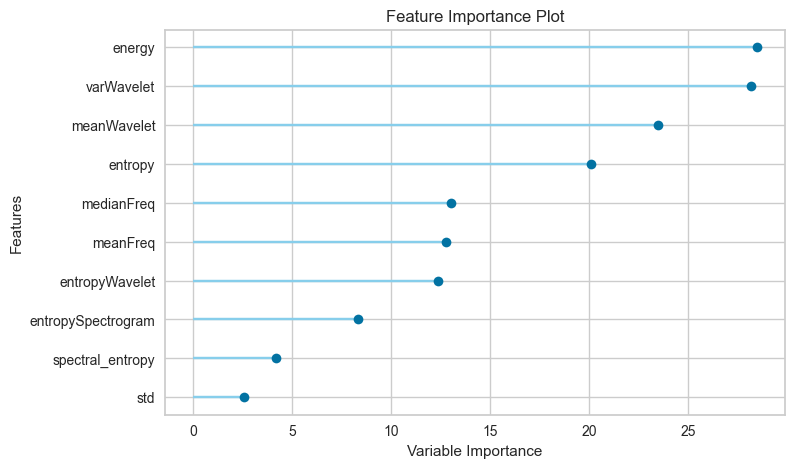

In [50]:
plot_model(svm, plot='feature')

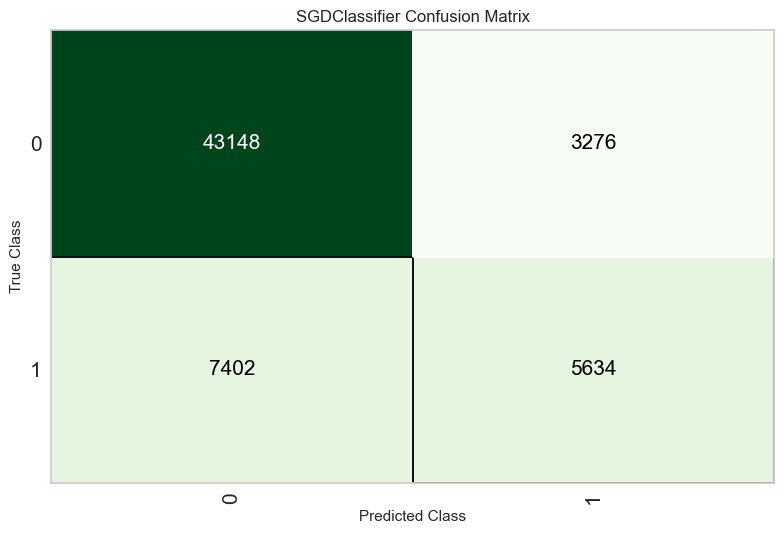

In [51]:
plot_model(svm, plot='confusion_matrix')

In [52]:
predictions_svm = predict_model(svm, data=features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,SVM - Linear Kernel,0.8221,0,0.8221,0.8075,0.8105,0.4122,0.4213,0.6844,0.1779,0.3490,0


In [53]:
get_incorrect_predictions(predictions_svm)

,varWavelet,entropyWavelet,meanFreq,crest,energy,entropySpectrogram,rms,meanWavelet,spectral_skewness,entropy,std,spectral_entropy,medianFreq,Label,prediction_label
51610,-0.197800,-0.429882,-1.341669,-0.667418,-0.198069,-0.111429,-0.513062,-0.506804,-0.500676,-0.457452,-0.513062,-0.244013,-1.343634,damaged,healthy
50566,-0.197972,-0.431807,-1.345769,-0.224180,-0.198248,-0.111429,-0.536253,-0.532383,-0.162671,-0.459614,-0.536253,-0.244507,-1.344188,damaged,healthy
100479,-0.197988,-0.432025,-1.344389,-0.587567,-0.198266,-0.111429,-0.541380,-0.538581,-0.267081,-0.459858,-0.541380,-0.244558,-1.344166,damaged,healthy
55010,-0.197808,-0.430081,-0.052786,0.130234,-0.198087,-0.111429,-0.514668,-0.512708,0.731206,-0.457655,-0.514667,-0.244087,-0.046447,healthy,damaged
6542,-0.197716,-0.429194,-0.483565,-0.652229,-0.197996,-0.111429,-0.507110,-0.506299,0.758243,-0.456644,-0.507109,-0.243831,-0.486912,healthy,damaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79191,-0.197988,-0.432027,-0.480759,0.494135,-0.198266,-0.111429,-0.541432,-0.539499,0.893887,-0.459860,-0.541432,-0.244558,-0.476673,healthy,damaged
6002,-0.197596,-0.428084,0.290858,-0.293382,-0.197879,-0.111429,-0.498940,-0.498799,0.138759,-0.455385,-0.498939,-0.243557,0.286833,healthy,damaged
99618,-0.197993,-0.432092,-0.480459,0.177693,-0.198271,-0.111429,-0.543624,-0.541457,0.902681,-0.459935,-0.543624,-0.244574,-0.477495,healthy,damaged
103236,-0.195666,-0.412290,0.807560,-0.336822,-0.195972,-0.111427,-0.427033,-0.429848,-0.275201,-0.437513,-0.427030,-0.239189,0.808716,healthy,damaged


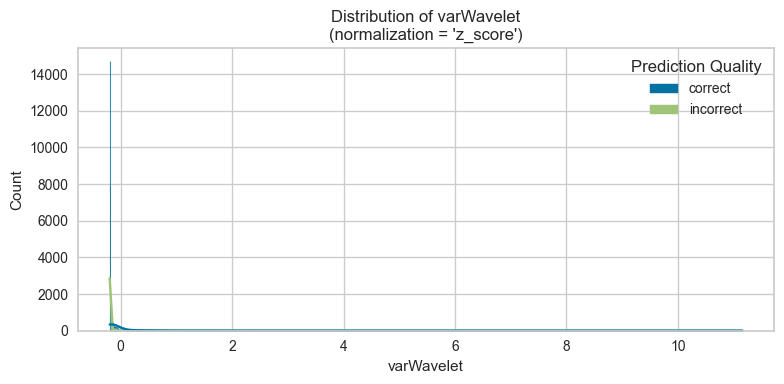

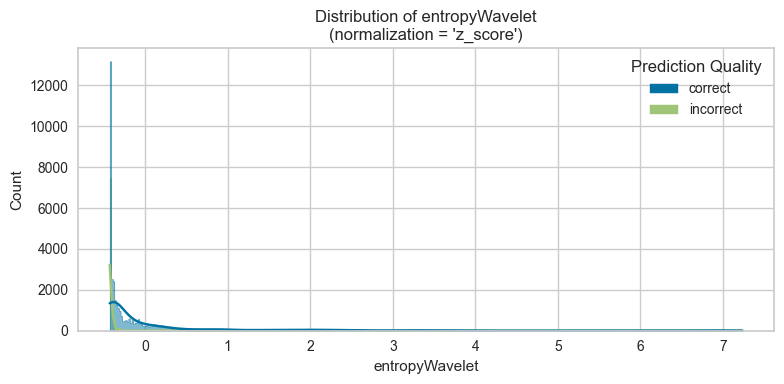

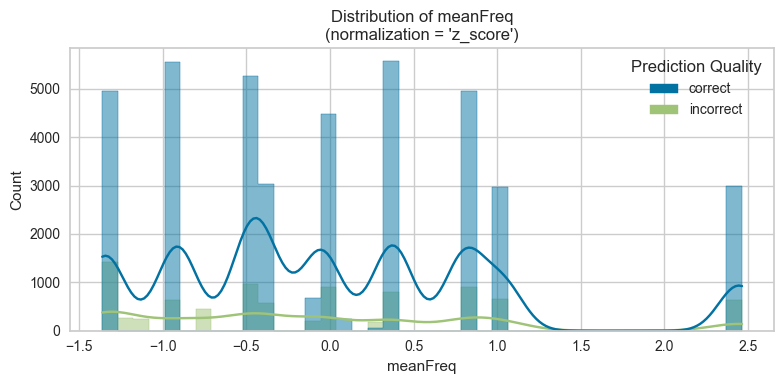

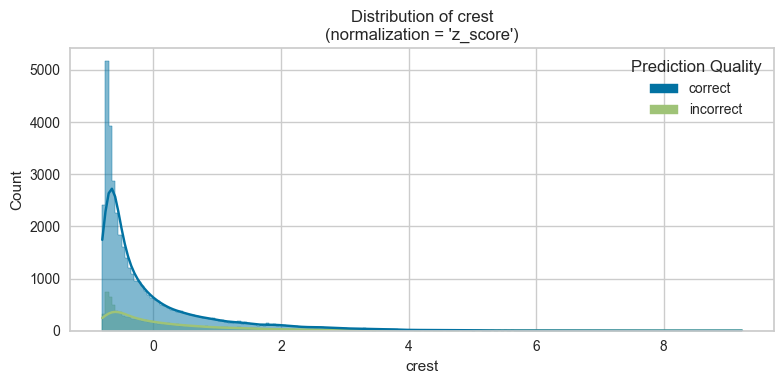

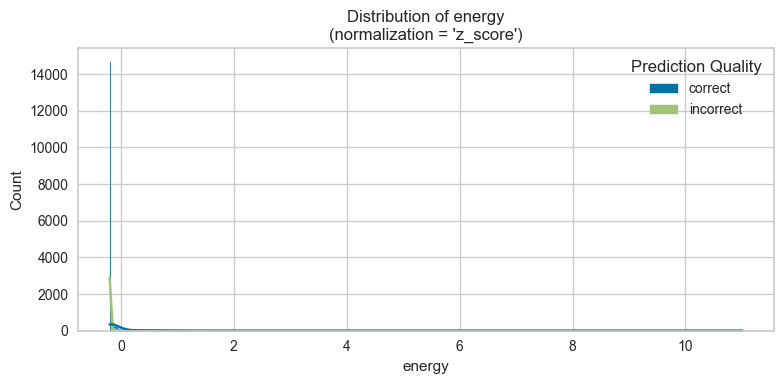

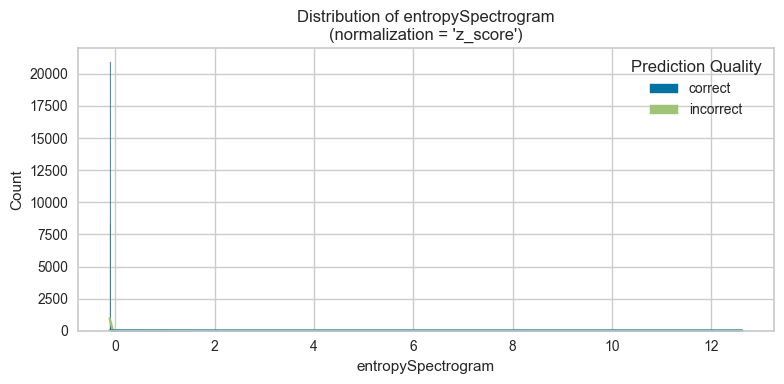

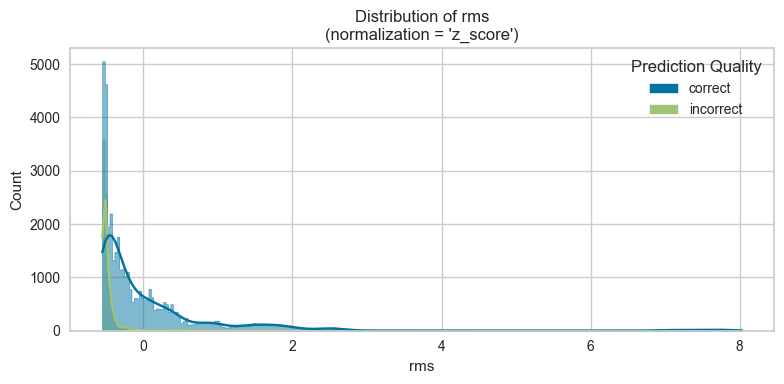

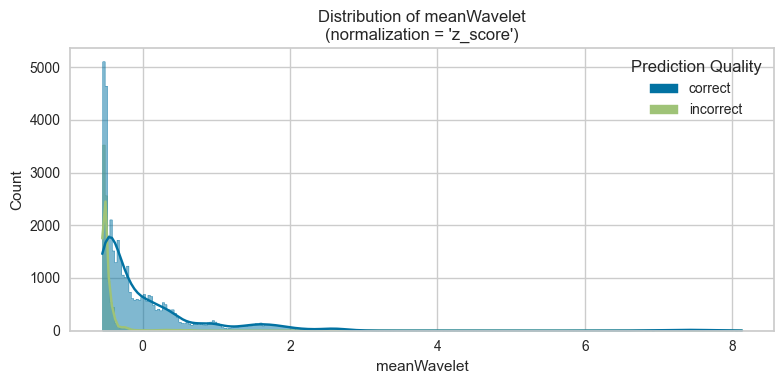

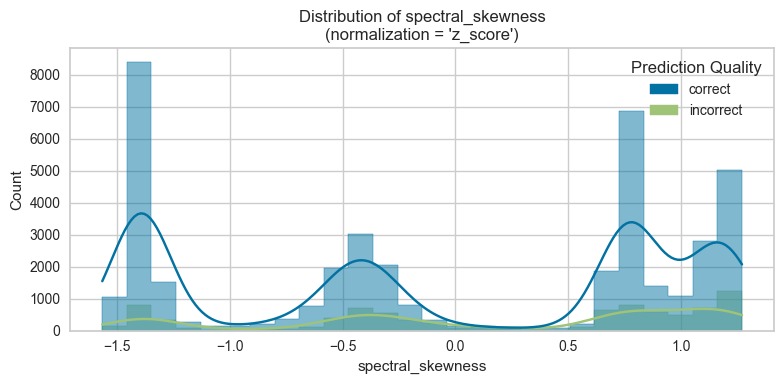

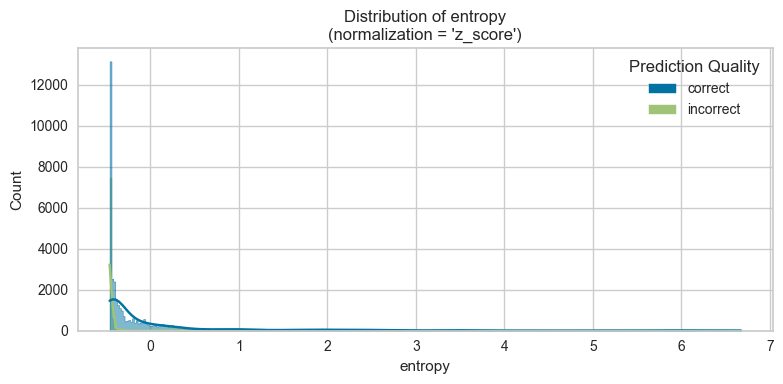

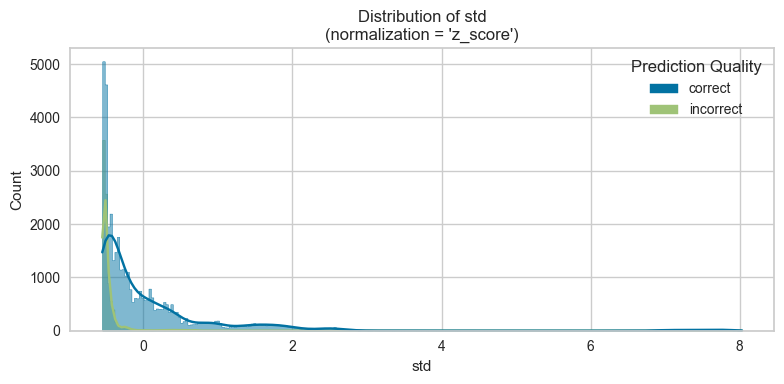

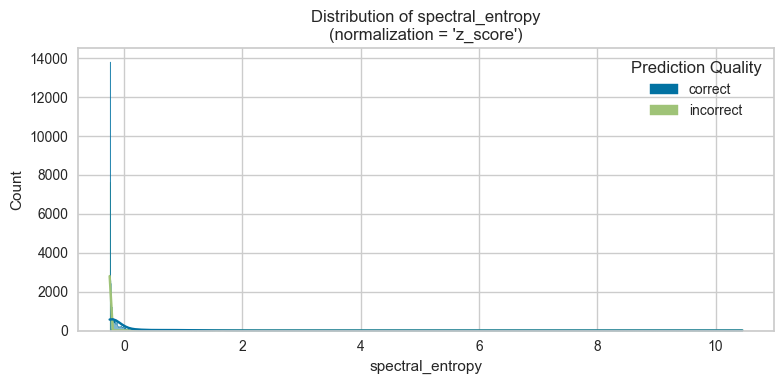

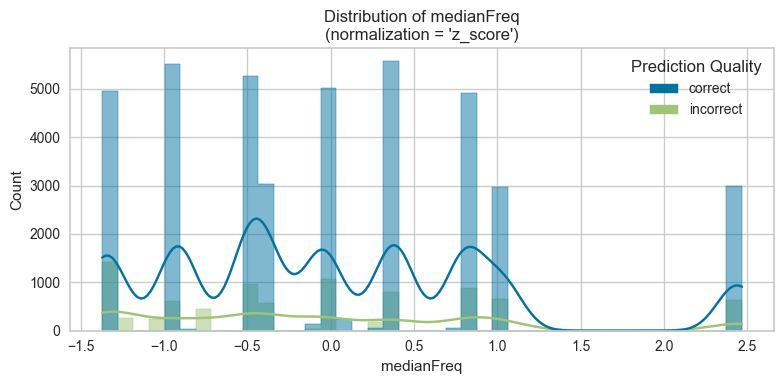

In [54]:
plotPredictionHistograms(predictions_svm, normalization_method)

# Experiment Setup (DL)

## Configure Data

In [55]:
train, test = train_test_split(normalized_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Train Shape: {train.shape} | Val Shape: {val.shape} | Test Shape: {test.shape}")

Train Shape: (158560, 14) | Val Shape: (39640, 14) | Test Shape: (49551, 14)


In [56]:
target = "Label"
num_labels = normalized_df['Label'].nunique()

categorical_cols = [
    col
    for col in features_df_training_normalized.select_dtypes(include=["object","category"]).columns
    if col != target
]

continuous_cols = features_df_training_normalized.select_dtypes(include=["number"]).columns.tolist()

In [57]:
print("Target:", target)
print("Categorical inputs:", categorical_cols)  
print("Continuous inputs:", continuous_cols)    

Target: Label
Categorical inputs: []
Continuous inputs: ['varWavelet', 'entropyWavelet', 'meanFreq', 'crest', 'energy', 'entropySpectrogram', 'rms', 'meanWavelet', 'spectral_skewness', 'entropy', 'std', 'spectral_entropy', 'medianFreq']


In [58]:
data_config = DataConfig(
    target=[target],
    continuous_cols=continuous_cols,
    categorical_cols=categorical_cols,
)

In [59]:
available_gpu=1 if torch.cuda.is_available() else 0
print(f"Available GPU: {'Yes' if available_gpu else 'No'}")

Available GPU: Yes


In [60]:
trainer_config = TrainerConfig(
    auto_lr_find=False,
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    batch_size=256,
)

optimizer_config = OptimizerConfig()

experiment_config = ExperimentConfig(
        project_name=experiment_name,
        run_name=f"{experiment_name}_run",
        log_target="tensorboard",
    )

In [61]:
tabnet_config = TabNetModelConfig(
        task="classification",
        n_d=33,
        n_a=46,
        n_steps=3,
        gamma=1.2864230491528987,
        embedding_dropout=0.1825276618254278,
        learning_rate=0.00468046516266798,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [62]:
tabnet_model = TabularModel(
        data_config=data_config,
        model_config=tabnet_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        verbose=True
    )

2025-10-08 10:19:15,933 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [63]:
tabnet_model.fit(train=train, validation=val)

Seed set to 42


2025-10-08 10:19:15,972 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-08 10:19:16,004 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-08 10:19:16,107 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: TabNetModel

2025-10-08 10:19:16,278 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-08 10:19:16,326 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _embedding_layer │ Identity         │      0 │ train │
│ 1 │ _backbone        │ TabNetBackbone   │  121 K │ train │
│ 2 │ _head            │ Identity         │      0 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 121 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 121 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 107                                                                                         
Modules in eval mode: 0

Output()

2025-10-08 10:23:45,366 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-08 10:23:45,366 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [64]:
tabnet_pred_df = tabnet_model.predict(test)
tabnet_pred_df.head(10)
tabnet_result = tabnet_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8658150434494019     │
│        test_auroc         │    0.9155538082122803     │
│     test_cohen_kappa      │    0.5157696008682251     │
│       test_f1_score       │    0.8658150434494019     │
│   test_hamming_distance   │    0.13418498635292053    │
│    test_jaccard_index     │    0.6342763304710388     │
│         test_loss         │    0.28779131174087524    │
│        test_loss_0        │    0.28779131174087524    │
│  test_matthews_corrcoef   │    0.5580756068229675     │
│      test_precision       │    0.8658150434494019     │
│        test_recall        │    0.8658150434494019     │
└───────────────────────────┴───────────────────────────┘

## GANDALF

In [65]:
gandalf_config = GANDALFConfig(
        task="classification",
        gflu_stages=8,
        gflu_dropout=0.20621973444441227,
        gflu_feature_init_sparsity=0.5069371167197942,
        learnable_sparsity=False,
        embedding_dropout= 0.06647823724375934,
        batch_norm_continuous_input=False,
        learning_rate=2.6124262014312122e-05,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [66]:
gandalf_model = TabularModel(
    data_config=data_config,
    model_config=gandalf_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)

2025-10-08 10:23:59,914 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [67]:
gandalf_model.fit(train=train, validation=val)

Seed set to 42


2025-10-08 10:23:59,955 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-08 10:23:59,979 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-08 10:24:00,100 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-10-08 10:24:00,151 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-08 10:24:00,193 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  8.5 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │      0 │ train │
│ 2 │ _head            │ Sequential       │     30 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 8.6 K                                                                                            
Non-trainable params: 8                                                                                            
Total params: 8.6 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 30                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


2025-10-08 10:31:48,076 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-08 10:31:48,078 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [68]:
gandalf_pred_df = gandalf_model.predict(test)
gandalf_pred_df.head(10)

,Label_damaged_probability,Label_healthy_probability,Label_prediction
122281,0.987332,0.012668,damaged
239138,0.649306,0.350694,damaged
39200,0.526993,0.473007,damaged
90804,0.634501,0.365499,damaged
102120,0.959871,0.040129,damaged
69082,0.957785,0.042215,damaged
9942,0.642841,0.357159,damaged
51610,0.643989,0.356011,damaged
215982,0.819672,0.180328,damaged
245967,0.734226,0.265774,damaged


In [69]:
gandalf_result = gandalf_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8078141808509827     │
│        test_auroc         │    0.8827330470085144     │
│     test_cohen_kappa      │    0.23619453608989716    │
│       test_f1_score       │    0.8078141808509827     │
│   test_hamming_distance   │    0.19218583405017853    │
│    test_jaccard_index     │    0.49252936244010925    │
│         test_loss         │    0.37090277671813965    │
│        test_loss_0        │    0.37090277671813965    │
│  test_matthews_corrcoef   │    0.29530930519104004    │
│      test_precision       │    0.8078141808509827     │
│        test_recall        │    0.8078141808509827     │
└───────────────────────────┴───────────────────────────┘

In [70]:
gandalf_top_features = gandalf_model.feature_importance().sort_values("importance", ascending=False)
gandalf_top_features

,Features,importance
12,medianFreq,1.000052
1,entropyWavelet,0.893368
11,spectral_entropy,0.891424
3,crest,0.650409
2,meanFreq,0.635667
4,energy,0.594126
0,varWavelet,0.548477
5,entropySpectrogram,0.545938
6,rms,0.523177
9,entropy,0.513067


In [71]:
add_top_features(gandalf_top_features, top_n=3)

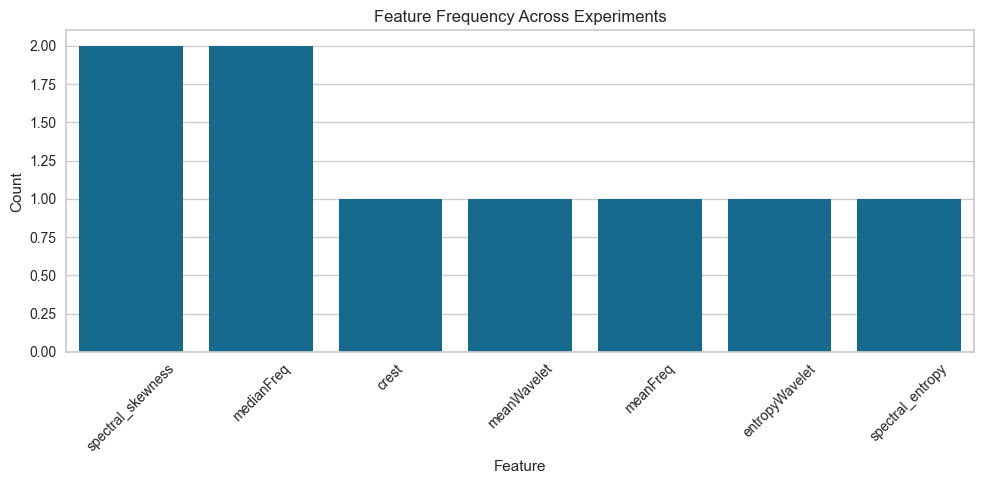

In [72]:
plot_feature_importance()